# Multi Layer Perceptron for Regression
* Author: Johannes Maucher
* Last Update: 23.10.2020

## Content and Goal
In this noteboook the same task as in [Machine Learning Implementation in a Nutshell](02RegressionPipe.ipynb) is addressed - prediction of annual charges of clients of an insurance company. However, now instead of applying a simple Linear Regression, now a <font color ="red"> Multi Layer Perceptron (MLP) is used for regression</font>. <font color ="red">The MLP is implemented, trained and evaluated in Keras</font>. Since preprocessing is the same as in the former notebook, you may directly jump to [section modelling](#modelling).

## Access Data

In this example, structured data is available from a .csv file. Data has been collected by a U.S. insurance company. For 1339 clients the following features are contained:
* age
* sex
* Body-Mass-Index (BMI)
* Number of children
* living region
* annual charges 

<p style="color:red">The goal is to learn a model, which predicts annual charges of clients from the other 5 features.</p>

In [1]:
import pandas as pd
import numpy as np

In [2]:
data="../Data/insurance.csv"
insurancedf=pd.read_csv(data,na_values=[" ","null"])
insurancedf.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Data Understanding
### Numeric features:

In [3]:
insurancedf.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Categorical Features:

In [4]:
catFeats=['sex','smoker','region']
for cf in catFeats:
    print("\nFeature %s :"%cf)
    print(insurancedf[cf].value_counts())
    


Feature sex :
male      676
female    662
Name: sex, dtype: int64

Feature smoker :
no     1064
yes     274
Name: smoker, dtype: int64

Feature region :
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64


## Preprocess Data

Non-numeric features must be transformed to a numeric representation:

In [5]:
from sklearn.preprocessing import LabelEncoder
for cf in catFeats:
    insurancedf[cf] = LabelEncoder().fit_transform(insurancedf[cf].values)

In [6]:
insurancedf.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


For **non-binary nominal features** a transformation into a numeric value is not sufficient, because algorithms interpret integers as ordinal data. Therefore non-binary nominal features must be **One-Hot-Encoded**. For columns of pandas dataframes the `get_dummies()`-function does the job. In the code-cell below the columns are reordered after One-Hot-Encoding, such that the attribute, which shall be predicted (charges) remains the last column:

In [7]:
insurancedfOH=pd.get_dummies(insurancedf,columns=["region"])
insurancedfOH.head()
ch=insurancedfOH["charges"]
insurancedfOH.drop(labels=['charges'], axis=1, inplace = True)
insurancedfOH.insert(len(insurancedfOH.columns), 'charges', ch)
insurancedfOH.head()

,age,sex,bmi,children,smoker,region_0,region_1,region_2,region_3,charges
0,19,0,27.900,0,1,0,0,0,1,16884.92400
1,18,1,33.770,1,0,0,0,1,0,1725.55230
2,28,1,33.000,3,0,0,0,1,0,4449.46200
3,33,1,22.705,0,0,0,1,0,0,21984.47061
4,32,1,28.880,0,0,0,1,0,0,3866.85520


### Prepare Data for Training and Test

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X=insurancedf.values[:,:-1] # all features, which shall be applied as input for the prediction
y=insurancedf.values[:,-1]  # annual charges, i.e. the output-value that shall be predicted

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [11]:
X_test[:5,:]

array([[52.   ,  1.   , 30.2  ,  1.   ,  0.   ,  3.   ],
       [47.   ,  0.   , 29.37 ,  1.   ,  0.   ,  2.   ],
       [48.   ,  1.   , 40.565,  2.   ,  1.   ,  1.   ],
       [61.   ,  1.   , 38.38 ,  0.   ,  0.   ,  1.   ],
       [51.   ,  0.   , 18.05 ,  0.   ,  0.   ,  1.   ]])

<a id='modelling'></a>
## Modelling
### Define Architecture of Neural Network

Keras provides two different methods to define the architecture of a neural network:

1. [Sequential Model](https://keras.io/guides/sequential_model/): A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. It is not appropriate, when A Sequential model is not appropriate when:
    * The model has multiple inputs or multiple outputs
    * Any of the layers has multiple inputs or multiple outputs
    * Layers must be shared
    * the network has a non-linear topology (e.g. a residual connection, a multi-branch model)
    
2. [Functional API](https://keras.io/guides/functional_api/): The Keras functional API is a way to create models that are more flexible than Sequential Models. The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

Since in this notebook only a simple linear neural network shall be implemented, the `Sequential Model` is applied here:


In [12]:
from tensorflow import keras

In the following code-cell a MLP is defined, which consists of a single hidden layer with 64 neurons. The output layer has only one neuron, since we like to learn a regression model. 

The first *layer* in the topology is actually no neural layer in the strict sense. It is just an operation, which performs normalisation of the input-values, i.e. all values are transformed, such that their mean is 0 and their standard-deviation is 1. <font color="red"> For all neural networks it is crucial, that their input values are small and in the same range!</font>.

Note that only for the first layer in the topology the input-shape must be defined. For all other layers the shape is infered from the previous layers and the number of units.

In [13]:
model=keras.Sequential()
model.add(keras.layers.BatchNormalization(input_shape=[X_train.shape[1]]))
model.add(keras.layers.Dense(units=64))
model.add(keras.layers.Dense(units=1))
model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 batch_normalization (BatchN  (None, 6)                24        


 ormalization)                                                   


 dense (Dense)               (None, 64)                448       


 dense_1 (Dense)             (None, 1)                 65        


Total params: 537


Trainable params: 525


Non-trainable params: 12


_________________________________________________________________


2022-02-25 14:12:33.610875: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Compile Training Parameters and perform Training
[Keras provides a bunch of training algorithms (optimizers)](https://keras.io/api/optimizers/). Each of these optimizers can be configured with a set of parameters. In the case that an optimizer shall be applied with it's default-parameters, the name of the optimizer (as a string) can the assigned to the argument `optimizer` in the `compile()`-method, for example:
```
model.compile(loss='mean_absolute_error', optimizer="sgd", metrics=['mean_absolute_error']) 
```
However, if the optimizers shall be configured individually, one must generate an object of the corresponding optimizer-class and configure the parameters as shown in the code-cell below. The reference to this object is then assigned to the argument `optimizer` in the `compile()`-method:

In [14]:
mysgd=keras.optimizers.SGD(learning_rate=0.001, momentum=0.4, nesterov=True, name="SGD")
model.compile(loss='mean_absolute_error', optimizer=mysgd, metrics=['mean_absolute_error'])

In [15]:
history = model.fit(
    X_train, y_train,
    verbose=False,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test,y_test),
    shuffle=True
)

In [16]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 22, 10

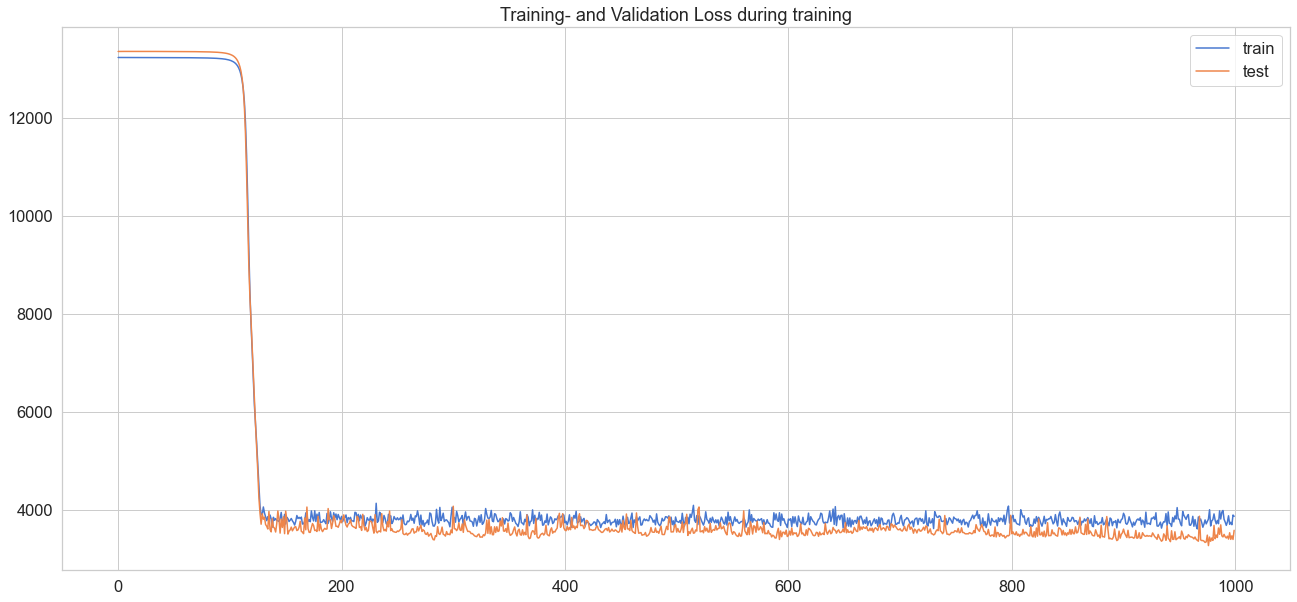

In [17]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Training- and Validation Loss during training")
plt.legend()
plt.show()

### Model Evaluation
Once the model has been learned it can be applied for predictions:

In [18]:
ypred=model.predict(X_test)

In [19]:
for pred, target in zip(ypred.flatten()[:10],y_test[:10]):
    print("Prediction: {0:2.2f} \t Target: {1:2.2f}".format(pred,target))

Prediction: 9146.77 	 Target: 9724.53
Prediction: 8362.44 	 Target: 8547.69
Prediction: 33203.50 	 Target: 45702.02
Prediction: 11787.16 	 Target: 12950.07
Prediction: 8579.38 	 Target: 9644.25
Prediction: 4426.83 	 Target: 4500.34
Prediction: 967.29 	 Target: 2198.19
Prediction: 10797.25 	 Target: 11436.74
Prediction: 7249.14 	 Target: 7537.16
Prediction: 5255.26 	 Target: 5425.02


In [20]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error,  median_absolute_error

In [21]:
def determineRegressionMetrics(y_test,y_pred,title=""):
    mse = mean_squared_error(y_test, y_pred)
    mad = mean_absolute_error(y_test, y_pred)
    rmsle=np.sqrt(mean_squared_error(np.log(y_test+1),np.log(y_pred+1)))# +1 for avoiding log(0) 
    r2=r2_score(y_test, y_pred)
    med=median_absolute_error(y_test, y_pred)
    print(title)
    print("Mean absolute error =", round(mad, 2))
    print("Mean squared error =", round(mse, 2))
    print("Median absolute error =", round(med, 2))
    print("R2 score =", round(r2, 2))
    print("Root Mean Squared Logarithmic Error =",rmsle)

In [22]:
determineRegressionMetrics(y_test,ypred)


Mean absolute error = 3577.3
Mean squared error = 40191085.69
Median absolute error = 772.1
R2 score = 0.75
Root Mean Squared Logarithmic Error = 0.519983520497234


#### Visualisation

Simple Visualisation with Matplotlib:

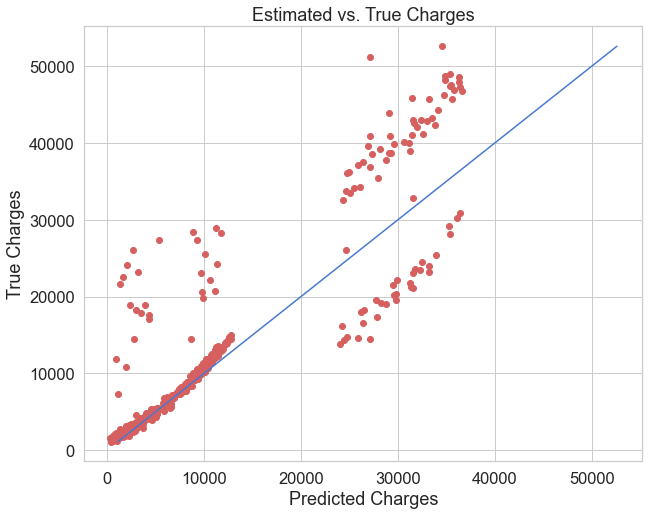

In [23]:
plt.figure(figsize=(10,8))
plt.plot(ypred,y_test,"ro")
plt.plot([np.min(y_test),np.max(y_test)],[np.min(y_test),np.max(y_test)])
plt.xlabel("Predicted Charges")
plt.ylabel("True Charges")
plt.title("Estimated vs. True Charges")
plt.show()

Split smokers and non-smokers:

In [24]:
y_test_smoker=y_test[X_test[:,4]==1]
y_pred_smoker=ypred[X_test[:,4]==1]

In [25]:
y_test_nonsmoker=y_test[X_test[:,4]==0]
y_pred_nonsmoker=ypred[X_test[:,4]==0]

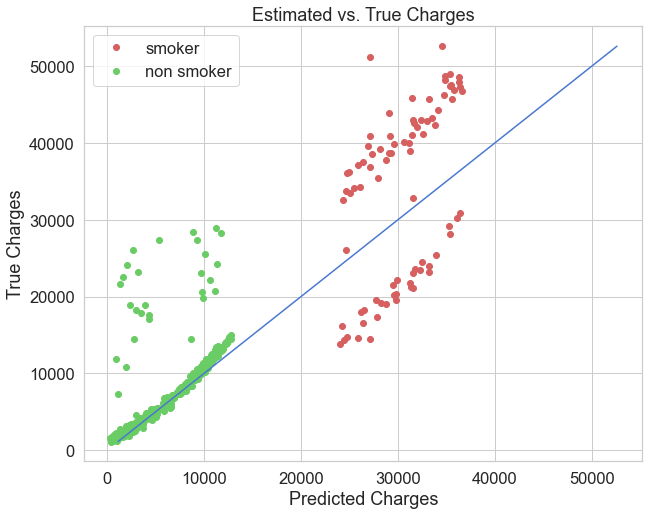

In [26]:
plt.figure(figsize=(10,8))
plt.plot(y_pred_smoker,y_test_smoker,"ro",label="smoker")
plt.plot(y_pred_nonsmoker,y_test_nonsmoker,"go",label="non smoker")
plt.plot([np.min(y_test),np.max(y_test)],[np.min(y_test),np.max(y_test)])
plt.xlabel("Predicted Charges")
plt.ylabel("True Charges")
plt.title("Estimated vs. True Charges")
plt.legend()
plt.show()